## Goal Statement:

The goal of this project is to build a working prediction model that can take a GitHub repo's Readme file. Then using NLP predict the primary programming langauge of that repo. 


The end product will be a function that can take in a readme file, and spit out the predicted language

In [1]:
import pandas as pd

### Step 1: Acquire the data. 
This CSV was generated using the prepare.read_lang() function in conjuction with a list of URLs provided from the prepare.get_all_links() function. 
It was saved to CSV for the sake saving Bandwith from github. They have enough people hitting their servers, so it's best to acquire once, and read localally. 

In [2]:
df = pd.read_csv('readmes.csv').rename(columns = {'Unnamed: 0': 'Repository'}).set_index('Repository')

Now let's take a quick peak at the data we are working with 

In [3]:
df.shape

(325, 2)

In [4]:
df.head()

,language,readme
Repository,,
iluwatar/java-design-patterns,Java,Design patterns implemented in Java Introducti...
elastic/elasticsearch,Java,Elasticsearch A Distributed RESTful Search Eng...
Snailclimb/JavaGuide,Java,点击订阅Java面试进阶指南(专为Java面试方向准备)。为什么要弄这个专栏? Specia...
ReactiveX/RxJava,Java,RxJava: Reactive Extensions for the JVM RxJava...
spring-projects/spring-boot,Java,Spring Boot Spring Boot makes it easy to creat...


In [5]:
df.isnull().sum()

language    0
readme      2
dtype: int64

Looks like 2 of our repos are missing readmes. Let's go ahead and drop those two instances with a drop na

In [6]:
df.dropna(inplace=True)

If we look at .head() from before, we can also see that some of our results are not in English.
To help fix that we can use google's detect language. If you don't already have that installed, it can be installed with a quick pip install

``` pip install langdetect ```

In [7]:
from langdetect import detect

In [8]:
print(detect('gatos y perros'))
print(detect('My name is Norrick!'))
print(type(detect('this will tell me the return type of detect')))

es
en
<class 'str'>


In [9]:
len([readme for readme in df.readme if detect(readme) == 'en'])

310

If we excluded our readmes we still have a decent amount of info to work with 
let's take a look at what other languages we have in there besides english.

(list of ISO 639 language codes can be found [here](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes) )

In [10]:
[detect(readme) for readme in df.readme if detect(readme) != 'en']

['zh-cn',
 'en',
 'zh-cn',
 'zh-cn',
 'zh-cn',
 'no',
 'no',
 'no',
 'tl',
 'zh-cn',
 'vi',
 'vi',
 'zh-cn',
 'no']

Looks like Norweigen and Chinese tend to be the biggest results right along side Vietnamese. 
Let's go ahead and remove non-english entries from our DataFrame

In [11]:
df['lang_code'] = [detect(readme) for readme in df.readme]

In [12]:
df = df[df['lang_code'] == 'en'].drop(columns='lang_code')

In [13]:
df.shape

(309, 2)

Now that we've take care of that portion of readmes, let's look at cleaning up the rest of the data
We've built some prebuilt functions that take care of the majority of the house keeping using regular expressions and stemming

In [14]:
import prepare

In [15]:
df['cleaned'] = [prepare.deep_clean(readme) for readme in df.readme]

In [16]:
df

,language,readme,cleaned
Repository,,,
iluwatar/java-design-patterns,Java,Design patterns implemented in Java Introducti...,design pattern implement introduct design patt...
elastic/elasticsearch,Java,Elasticsearch A Distributed RESTful Search Eng...,elasticsearch distribut rest search engin elas...
ReactiveX/RxJava,Java,RxJava: Reactive Extensions for the JVM RxJava...,rxjava reactiv extens jvm rxjava vm implement ...
spring-projects/spring-boot,Java,Spring Boot Spring Boot makes it easy to creat...,spring boot spring boot make easi creat spring...
kdn251/interviews,Java,Interviews Your personal guide to Software Eng...,interview person guid softwar engin technic in...
square/retrofit,Java,Retrofit Type-safe HTTP client for Android and...,retrofit typesaf http client android squar inc...
square/okhttp,Java,OkHttp An HTTP & HTTP/2 client for Android and...,okhttp http http client android applic inform ...
google/guava,Java,Guava: Google Core Libraries for Java Guava is...,guava googl core librari guava set core librar...
PhilJay/MPAndroidChart,Java,⚡️ A powerful & easy to use chart library for ...,power easi use chart librari android chart io ...


Now that we have some cleaner readmes to work with, let's go ahead and start diving into the Data

In [17]:
import nltk
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def n_gram_series(series, n):
    return pd.Series(nltk.ngrams(''.join(series).split(), n)).value_counts()

def generate_freq_for_cloud(ngram_valuecount):
    return {' '.join(k): v for k, v in ngram_valuecount.to_dict().items()}

def wordcloud_img_from_ngram(series,n,width=400,height=400):
    ''' Generates an wordcloud image of popular phrases in a pandas series of strings 
    Series: Panda's series of string objects
    n: number of words in a phrase (NLTK ngrams)
    height/width: size of wordcloud image '''
    ngram_series = n_gram_series(series,n)
    freq = generate_freq_for_cloud(ngram_series)
    return WordCloud(background_color='white', width=width, height=height).generate_from_frequencies(freq)

In [18]:
img = wordcloud_img_from_ngram(df.cleaned,2,height=800,width=800)

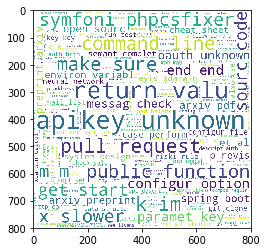

In [19]:
plt.figure(figsize=(8,4))
plt.imshow(img)

It looks like there are a few instances of single letter words. let's take a quick look at that by building a function that shows us the single letter words in an article. Then apply it to each cleaned readme

In [20]:
def one_letter_words(article):            
    return [word for word in article.split() if len(word) == 1]

In [21]:
[one_letter_words(cleaned) for cleaned in df.cleaned]

[[],
 ['x',
  'h',
  't',
  'h',
  't',
  'h',
  't',
  'h',
  'h',
  'h',
  't',
  't',
  'h',
  't',
  'h',
  't',
  'h',
  'h',
  'h'],
 ['x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'n',
  'n',
  'v',
  'v',
  'v',
  'v',
  'v',
  'v',
  'v',
  'v',
  'w',
  'w',
  'v',
  'v',
  'c',
  'x',
  's',
  'n',
  'n',
  'x',
  'x',
  'x',
  'x',
  'c'],
 ['v', 'f'],
 ['p',
  'n',
  'p',
  'n',
  'n',
  'o',
  'o',
  'o',
  'o',
  'o',
  'o',
  'b',
  'b',
  'o',
  'g',
  'v',
  'e',
  'v',
  'e',
  'v',
  'v',
  'v',
  'v',
  'v',
  'v',
  'v',
  'v',
  'v',
  'n',
  'k',
  'k',
  'e',
  'e',
  'v',
  'v',
  'e',
  'v',
  'n',
  'n',
  'v',
  'v',
  'v',
  'v',
  'v',
  'v',
  'v',
  'v',
  'v',
  'k',
  'k',
  'k',
  'k',
  'n',
  'n',
  'n',
  'n',
  'x',
  'x',
  'x',
  'h',
  'e',
  'l'],
 ['r', 'r'],
 ['x', 'x', 'x', 'x', 'r', 'r'],
 [],
 [],
 [],
 ['v', 'v', 'v', 'v', 'x', 'v'],
 [],
 ['r'],
 [],
 ['d', 'd', 'd', 'c', 'c', 'c', 'c', 'c', 'c', 'c'],
 ['x'],
 ['j', '

It looks like a lot of the cleaned readmes have 1 letter words.
Let's go ahead and remove them, since there likely isn't much value to be gained from those single letters. especiall since some of them (like the x) are likely just a token that doesn't mean much in the context of language

In [22]:
def one_letter_words(article,drop=False):
    '''This function returns all one letter words in an article. 
    OR if you would like to drop those one letter words.
    the Drop Keyword will return the original article with none of the one letter words'''
    if drop:
        return ' '.join([word for word in article.split() if len(word)>1])
    return [word for word in article.split() if len(word) == 1]

In [23]:
df.cleaned = [one_letter_words(cleaned,drop=True) for cleaned in df.cleaned]

Let's take a look at a value count of all the words in all of the readmes

In [24]:
all_words = ' '.join(df.cleaned)

In [25]:
pd.Series(all_words.split()).value_counts().head()

use       3247
file      1172
instal    1107
code       966
option     942
dtype: int64

Here are some of the most used words in all of the Readme files. Let's take a look at that as a breakdown between each of the langauges. 

First let's make a list of all the languages we are working with

In [26]:
languages = list(df.language.value_counts().index)

In [27]:
print(languages)

['C++', 'php', 'Java', 'Python', 'Rust', 'Ruby']


In [28]:
python_words = ' '.join(df[df.language == 'Python'].cleaned)

In [29]:
pd.Series(python_words.split()).value_counts().head()

use        839
unknown    539
file       448
instal     431
data       398
dtype: int64

Now, we're going to want to do the above action but for each of the languages listed above. 

In [30]:
words_by_lang = {lang: ' '.join(df[df.language == lang].cleaned) for lang in languages}

In [31]:
value_counts_by_lang = {lang:pd.Series(words_by_lang[lang].split()).value_counts() for lang in words_by_lang}

In [32]:
for lang in value_counts_by_lang:
    print(lang)
    print(value_counts_by_lang[lang].head())
    print('\n')

C++
use       768
key       492
valu      453
return    450
build     382
dtype: int64


php
use         692
function    345
class       257
new         246
default     222
dtype: int64


Java
use       313
licens    189
build     133
depend    125
spring    111
dtype: int64


Python
use        839
unknown    539
file       448
instal     431
data       398
dtype: int64


Rust
use       254
build     123
instal     95
run        93
code       77
dtype: int64


Ruby
use      381
end      292
code     166
class    152
tag      128
dtype: int64




It looks like use is the most used word across all languages, and likely isn't offering much information to our model.
Let's go ahead and make a note to add that to the stop words

In [33]:
df['cleaned'] = [prepare.deep_clean(readme,bonus_stopwords = ['use']) for readme in df.readme]
df.cleaned = [one_letter_words(cleaned,drop=True) for cleaned in df.cleaned]

In [34]:
df.head()

,language,readme,cleaned
Repository,,,
iluwatar/java-design-patterns,Java,Design patterns implemented in Java Introducti...,design pattern implement introduct design patt...
elastic/elasticsearch,Java,Elasticsearch A Distributed RESTful Search Eng...,elasticsearch distribut rest search engin elas...
ReactiveX/RxJava,Java,RxJava: Reactive Extensions for the JVM RxJava...,rxjava reactiv extens jvm rxjava vm implement ...
spring-projects/spring-boot,Java,Spring Boot Spring Boot makes it easy to creat...,spring boot spring boot make easi creat spring...
kdn251/interviews,Java,Interviews Your personal guide to Software Eng...,interview person guid softwar engin technic in...


In [35]:
words_by_lang = {lang: ' '.join(df[df.language == lang].cleaned) for lang in languages}

value_counts_by_lang = {lang:pd.Series(words_by_lang[lang].split()).value_counts() for lang in words_by_lang}

for lang in value_counts_by_lang:
    print(lang)
    print(value_counts_by_lang[lang].head())
    print('\n')

C++
key       492
valu      453
return    450
build     382
file      339
dtype: int64


php
function    345
class       257
new         246
default     222
file        198
dtype: int64


Java
licens     189
build      133
depend     125
spring     111
project    108
dtype: int64


Python
unknown    539
file       448
instal     431
data       398
option     372
dtype: int64


Rust
build     123
instal     95
run        93
code       77
cargo      72
dtype: int64


Ruby
end       292
code      166
class     152
method    128
tag       128
dtype: int64




Let's checkout all of the words again, and see how they stack up between languages

In [36]:
all_words = ' '.join(df.cleaned)

In [37]:
pd.Series(all_words.split()).value_counts().head(20)

file        1172
instal      1107
code         966
option       942
support      894
run          812
set          812
valu         798
return       784
exampl       779
build        760
data         734
see          717
key          707
new          704
default      696
version      686
function     663
command      660
list         649
dtype: int64

In [38]:
value_counts_by_lang['all'] = pd.Series(all_words.split()).value_counts()

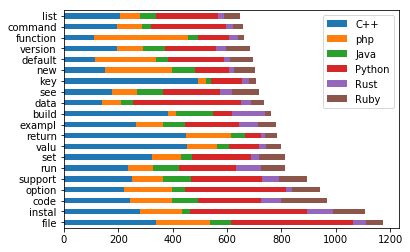

In [39]:
pd.DataFrame(value_counts_by_lang).fillna(0).sort_values('all',ascending=False).head(20).drop(columns='all').plot.barh(stacked=True)

If we take a look, there is definitely a large difference in language between sme of these key words, which bodes well for our theory that we can predict based on the language in a readme. 
Let's set up an initial model and see how it goes

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer


Let's go ahead and pull out our X and y variables from the Dataframe, and then split them into train and test

In [41]:
X = df['cleaned']
y = df[['language']]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 123)

Now let's turn our cleaned readme's into a "word matrix" where each field is a score of how 'rare' a word is in a readme file

In [42]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
train_vector = vectorizer.transform(X_train) 

Awesome, now we can use that as our X variable for our classifier (but we have to turn it from a sparce matrix to a dense matrix first) 

In [43]:
nb_classifier = GaussianNB().fit(train_vector.todense(),y_train)

In [44]:
y_train['predicted'] = nb_classifier.predict(train_vector.todense())

In [45]:
y_train.head()

,language,predicted
Repository,,
github/scientist,Ruby,Ruby
h2o/h2o,C++,C++
tymondesigns/jwt-auth,php,php
pjreddie/darknet,C++,C++
octalmage/robotjs,C++,C++


Let's use some evaluation metrics to see how we did! 

In [56]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [57]:
print(accuracy_score(y_train['language'], y_train['predicted']))

0.9956709956709957


Not a bad model! At least for the training set. Let's go ahead and take a look at it on the test data, and see if the model still holds up!

In [48]:
test_vector = vectorizer.transform(X_test) 

In [49]:
y_test['predicted'] = nb_classifier.predict(test_vector.todense())

In [61]:
print(type(float(accuracy_score(y_test['language'], y_test['predicted']))))

<class 'float'>


Let's go ahead and turn this classifier into a function that can be used to make a prediction for future readmes! 

In [53]:
def guesslang(string):
    word_matrix = vectorizer.transform([string])
    return nb_classifier.predict(word_matrix.todense())[0]

In [54]:
guesslang('hello world')

'Rust'

In [71]:
def classif(X,y,model,vector,model_name):
    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=666)
    vector.fit(X_train)
    train_matrix = vector.transform(X_train)
    test_matrix = vector.transform(X_test)
    model.fit(train_matrix.todense(),y_train)
    y_train['predicted'] = model.predict(train_matrix.todense())
    y_test['predicted'] = model.predict(test_matrix.todense())
    return {'train_acc': float(accuracy_score(y_train['language'],y_train['predicted'])),
    'test_acc' :float(accuracy_score(y_test['language'],y_test['predicted'])),
    'model_name':model_name}
    

In [76]:
from sklearn.tree import DecisionTreeClassifier as tree
from sklearn.ensemble import RandomForestClassifier as forrest
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import SGDClassifier

In [77]:
model_dict = {'SGradDecen':SGDClassifier(),'knn':KNN(),'supportvectormachine':SVC(),'randomforrest':forrest(),'tree':tree()}
vector = CountVectorizer()

In [78]:
for model in model_dict:
    print(classif(X,y, model_dict[model],vector,model))

{'train_acc': 0.9696969696969697, 'test_acc': 0.46153846153846156, 'model_name': 'SGradDecen'}
{'train_acc': 0.6103896103896104, 'test_acc': 0.358974358974359, 'model_name': 'knn'}
{'train_acc': 0.3939393939393939, 'test_acc': 0.21794871794871795, 'model_name': 'supportvectormachine'}
{'train_acc': 0.987012987012987, 'test_acc': 0.3974358974358974, 'model_name': 'randomforrest'}
{'train_acc': 1.0, 'test_acc': 0.6794871794871795, 'model_name': 'tree'}


In [72]:
for model in model_dict:
    print(classif(X,y, model_dict[model],vector,model))

{'train_acc': 0.6103896103896104, 'test_acc': 0.358974358974359, 'model_name': 'knn'}
{'train_acc': 0.3939393939393939, 'test_acc': 0.21794871794871795, 'model_name': 'supportvectormachine'}
{'train_acc': 0.987012987012987, 'test_acc': 0.38461538461538464, 'model_name': 'randomforrest'}
{'train_acc': 1.0, 'test_acc': 0.6666666666666666, 'model_name': 'tree'}
